### Other Denoising Methods
This notebook is intended to demonstrate the use and quirks of other denoising methods we've used in this workshop. We'll start off with wavelet denoising, then look at how to use TV and BM3D denoisers using pre-build systems. Keep this around for the daisy-chaining portion!

Let's start off by pulling in a useful demo image for denoising:

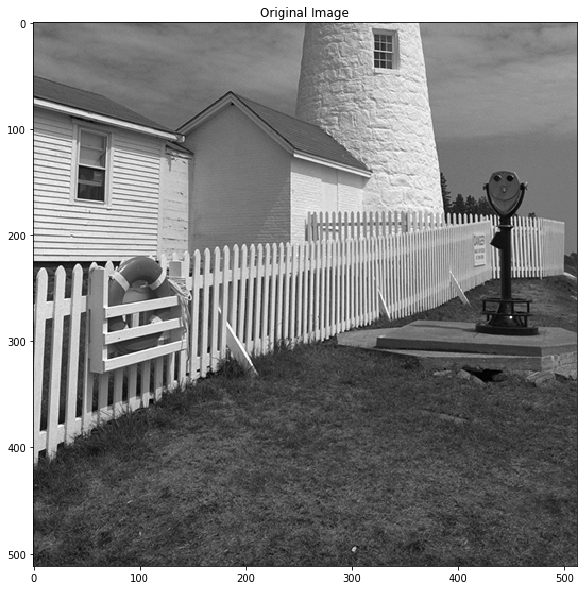

In [7]:
import imageio, os, utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 10]

cwd = os.getcwd()
image_folder = cwd + "/images/"
example_image_path = image_folder + "lighthouse.png"
test_image = utils.normalize_to_01(imageio.imread(example_image_path))

fig = plt.figure()
plt.imshow(test_image, cmap='gray'); plt.title('Original Image')
plt.show()

## Wavelet Denoising
We'll be using wavelet denoising as our first denoising method. We've included our own homebrew version in wavelet_denoising.py, which we'll be using here. If you think our method is inefficient or you want to play with other wavelets, we highly recommend using pywavelets.

Recall that when we do a wavelet decomposition, we'll get a pyramid of representations, the depth of which we can tweak, or just let run to the maximum possible. The deepest such pyramid you can get will have $L = \log_2(N)$ layers, if your image is $N \times N$. 

When you're trying these methods out, note that our code is a bit limited in that it requires the input image to have a side length that's a multiple of 2. lighthouse.png is $512 \times 512$, but for others you may have to do some cropping.

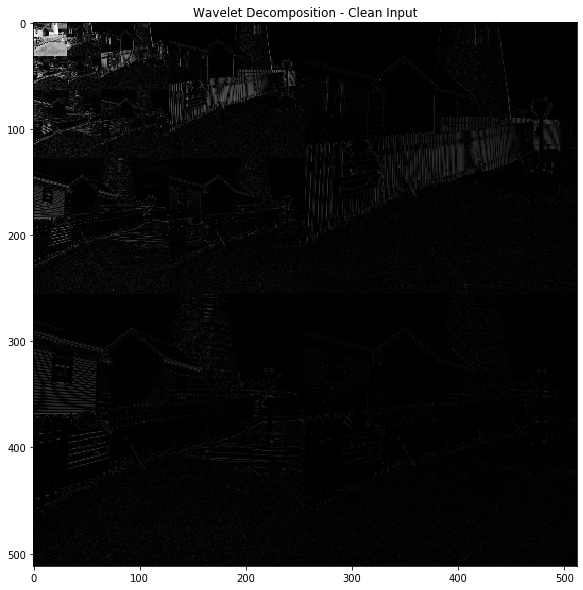

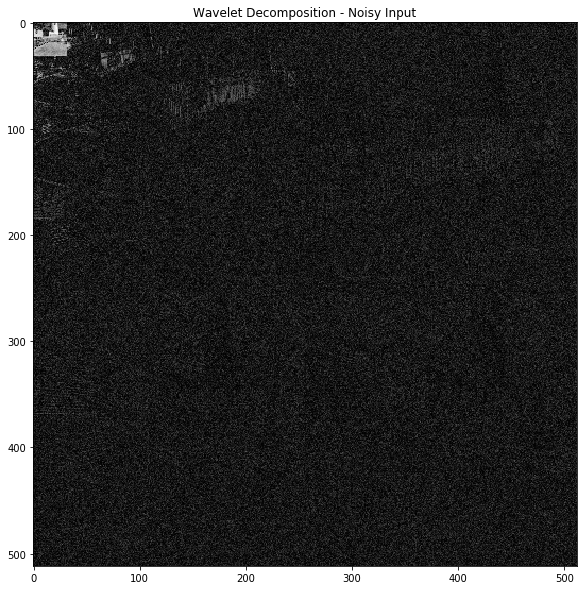

In [8]:
import wavelet_denoising
import corruption_models

example_image_path = image_folder + "lighthouse.png"
test_image = utils.normalize_to_01(imageio.imread(example_image_path))

noise_sigma = 0.3
noisy_image = corruption_models.add_gaussian_noise(test_image, sigma=noise_sigma)

# log abs value plus one of coeffs

# Let's demo a wavelet decomposition
centered_test_image = test_image - np.mean(test_image,axis=(0,1))
wavelet_coeffs = wavelet_denoising.forward_wavelet_transform(centered_test_image, n_levels=4)
wavelet_coeffs = np.log10(np.abs(wavelet_coeffs) + 1.)
fig = plt.figure()
plt.imshow(wavelet_coeffs, cmap='gray'); plt.title('Wavelet Decomposition - Clean Input')
plt.show()

centered_noisy_image = noisy_image - np.mean(noisy_image,axis=(0,1))
wavelet_coeffs_noisy = wavelet_denoising.forward_wavelet_transform(centered_noisy_image, n_levels=4)
wavelet_coeffs_noisy = np.log10(np.abs(wavelet_coeffs_noisy) + 1.)
fig = plt.figure()
plt.imshow(wavelet_coeffs_noisy, cmap='gray'); plt.title('Wavelet Decomposition - Noisy Input')
plt.show()

As we just demonstrated, noisy images have a much more messy wavelet decomposition. What happens as we add more layers to the wavelet decomposition? Or what about other test images? 

### Denoising with wavelets
In order to denoise the above noisy image, what we'll do is perform soft thresholding on the noisy wavelet decomposition, and then transform back into the image domain. We encourage you to try altering wavelet_denoise.py to try hard thresholding or other forms of thresholding - what happens?

In addition, if you aren't satisfied with these results, try going into the waveletDenoise() method in wavelet_denoise.py and changing the max_n_levels variable. Does that help or hurt your reconstruction?

Below is a brief demo.

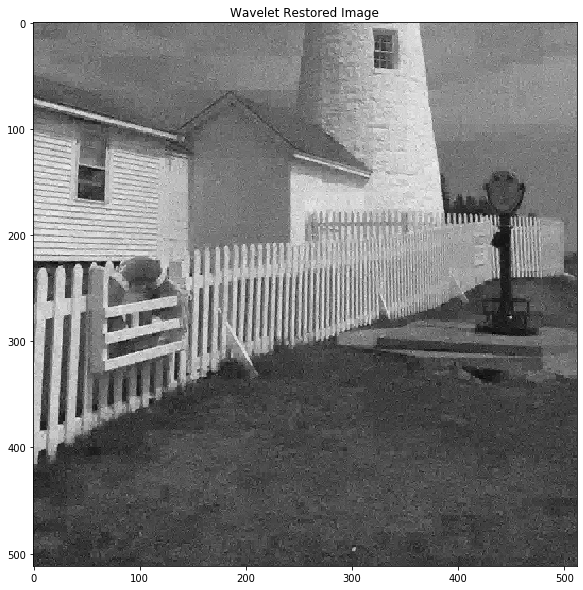

In [9]:
example_image_path = image_folder + "lighthouse.png"
test_image = utils.normalize_to_01(imageio.imread(example_image_path))
noise_sigma = 0.1
noisy_image = corruption_models.add_gaussian_noise(test_image, sigma=noise_sigma)

# What happens when this goes up? Why?
threshold_parameter = 0.12

# hard or soft thresholding

channelwise_means = np.mean(noisy_image,axis=(0,1))
centered_noisy_image = noisy_image - channelwise_means
thresholding_method = 'soft' # change this to 'hard' to try hard thresholding
centered_restored_image = wavelet_denoising.waveletDenoise(centered_noisy_image, threshold_parameter, thresholding=thresholding_method)
restored_image = centered_restored_image + channelwise_means
fig = plt.figure()
plt.imshow(restored_image, cmap='gray'); plt.title('Wavelet Restored Image')
plt.show()

### Total Variation Denoising
Next, we'll be denoising by regularizing our image with a total variation penalty.
Total variation penalties are a case where you want to be careful about computation. The actual methods used to do total variation denoising are pretty interesting, and worth a look if you find this field useful. However, we don't have time to go through the intricacies of TV denoising, so we'll be using pre-baked TV denoising today.

Again, try using different parameter settings - the differences should be noticeable.

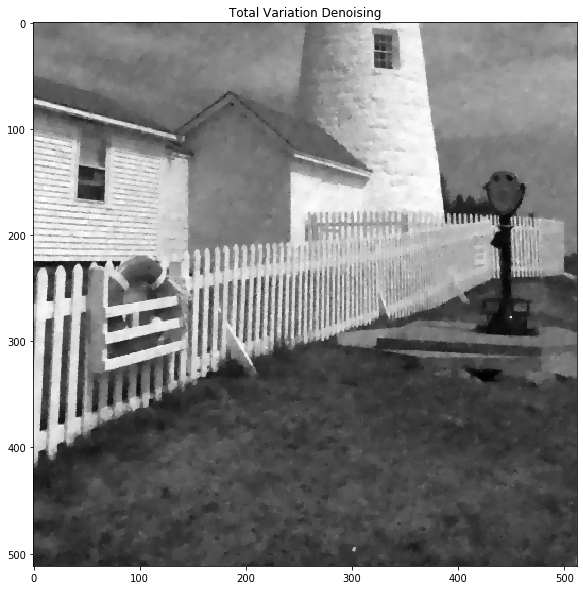

In [20]:
from skimage import restoration
example_image_path = image_folder + "lighthouse.png"
test_image = utils.normalize_to_01(imageio.imread(example_image_path))

noise_sigma = 0.1
noisy_image_gray = corruption_models.add_gaussian_noise(test_image, sigma=noise_sigma)

regularization_lambda = 0.1 # Regularization strength - this is actually half the lambda value used in the optimization
maxiters = 100 # Number of optimization iterations to go through before stopping.
multichannel = False # Change to True if you want to use for color images

restored_image_tv = restoration.denoise_tv_chambolle(noisy_image_gray, weight=regularization_lambda, n_iter_max=maxiters, multichannel=multichannel)
fig = plt.figure()
plt.imshow(restored_image_tv, cmap='gray'); plt.title('Total Variation Denoising')
plt.show()

### BM3D
In the workshop we discussed how BM3D works, by leveraging patch similarity across the image. Coding up an efficient BM3D implementation is out of scope here, but fortunately some other people have done this before. Below is how we might go about that. 

Something to try: how sensitive is BM3D to incorrect $\sigma$?

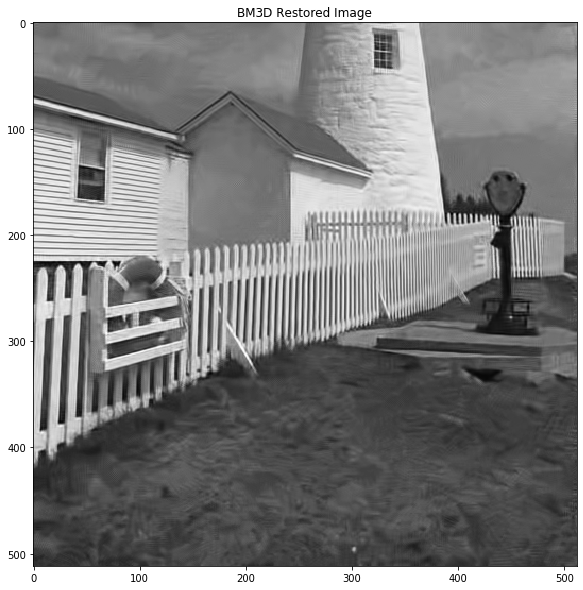

In [21]:
import pybm3d

def bm3d_denoise(input_image, sigma):
    denoised_img = pybm3d.bm3d.bm3d(input_image, sigma)
    return denoised_img

bm3d_restored_image = bm3d_denoise(noisy_image_gray, sigma=noise_sigma)

fig = plt.figure()
plt.imshow(bm3d_restored_image, cmap='gray'); plt.title('BM3D Restored Image')
plt.show()

### Color images
Earlier we discussed denoising color images, and mentioned that wavelet methods tend to denoise in different spaces than RGB. In fact, if you've looked at wavelet_denoise.py you'll note that if you pass in an RGB image, it will by default denoise in YCbCr. Try taking that out - what happens?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


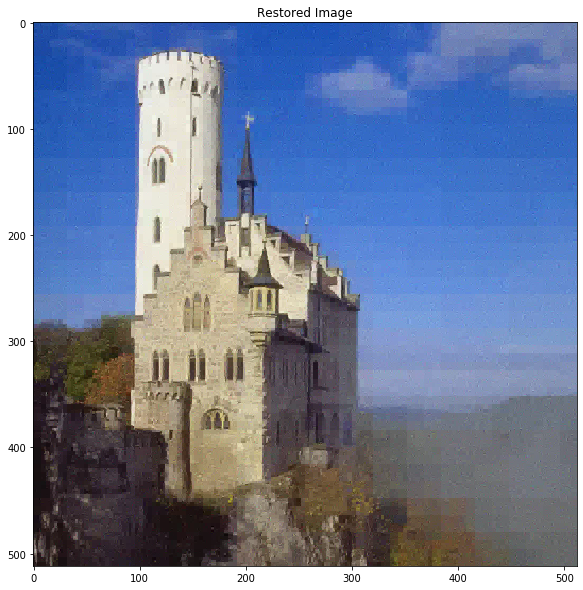

In [22]:
# test_image_path = image_folder + "owls.jpg"
# test_image = utils.normalize_to_01(imageio.imread(test_image_path))
# test_image = test_image[20:276,115:371, :]

test_image_path = image_folder + "Lichtenstein.png"
test_image = utils.normalize_to_01(imageio.imread(test_image_path))
noisy_image = corruption_models.add_gaussian_noise(test_image, sigma=noise_sigma)


threshold_parameter = 0.1
channelwise_means = np.mean(noisy_image,axis=(0,1))
centered_noisy_image = noisy_image - channelwise_means
centered_restored_image = wavelet_denoising.waveletDenoiseColor(centered_noisy_image, threshold_parameter)
restored_image = centered_restored_image + channelwise_means
fig = plt.figure()
plt.imshow(restored_image); plt.title('Restored Image')
plt.show()